# **Facial Emotion Detection**

## **Problem Definition**

**The context:** Why is this problem important to solve?<br>
  
**Answer**: facial recognition may be used in various places. Emotion detection can be useful in marketing and politics (for example, there was an article about Russian powers that have focus groups to define people's reactions, and they use a facial recognition system).

**The objectives:** What is the intended goal?<br>
**Answer**: To recognize 4 facial emotions (happiness, sadness, surpriseness, wonder, neutralness) in the most accurate way that possible.


**The key questions:** What are the key questions that need to be answered?<br>
**Answer**:
1. What kind of data we have to solve this task?
2. What kind of labels pretraining data has?



**The problem formulation:** What are we trying to solve using data science?

**Answer**: We are trying to define facial expressions of people (exactly 4). This can be used in marketing, polytical technologies, lie detection systems and more.



## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

### **Let us load and unzip the data**

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [4]:
# Path to zip file
path_to_zip = '/content/drive/MyDrive/Facial_emotion_images.zip'

# Reading data with reading mode
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
  # Extracting data
  zip_ref.extractall()

## **Visualizing our Classes**

Let's look at our classes.

**Write down your observation for each class. What do you think can be a unique feature of each emotion, that separates it from the remaining classes?**


In [30]:
# Generalizing data to make it accessible for each of the sections
folder_path = "Facial_emotion_images/"

# Initializing figure parameters
plt.figure(figsize=(10, 10))

def render_images(expression):
  # Looping to add subplots to figure
  for i in range(1, 10):
      # Creating a subplot within the main plt
      plt.subplot(3, 3, i)

      # Loading image into memory
      img = load_img(folder_path + "train/" + expression + "/" +
                    os.listdir(folder_path + "train/" + expression)[i], target_size = (img_size, img_size))

      # Display as an image
      plt.imshow(img)

  # Render
  plt.show()

<Figure size 1000x1000 with 0 Axes>

### **Happy**

**Observations and Insights:__**
For happiness: mouth and lips, teeth can be visible

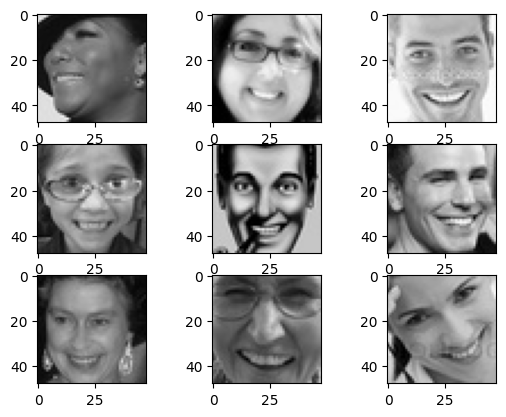

In [ ]:
render_images("happy")

### **Sad**

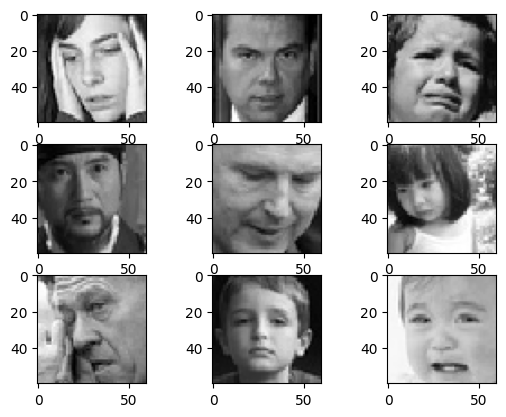

In [ ]:
render_images("sad")

**Observations and Insights:__**

For sadness: lips, eyes and eyebrows

### **Neutral**

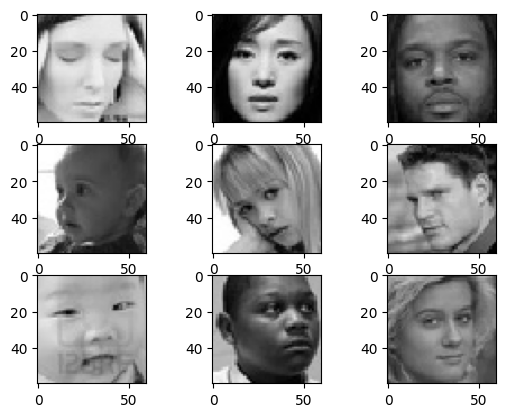

In [ ]:
render_images("neutral")

**Observations and Insights:__**


For neutral: everything is in a neutral position (lips, mouth, eyes, eyebrows)

### **Surprised**

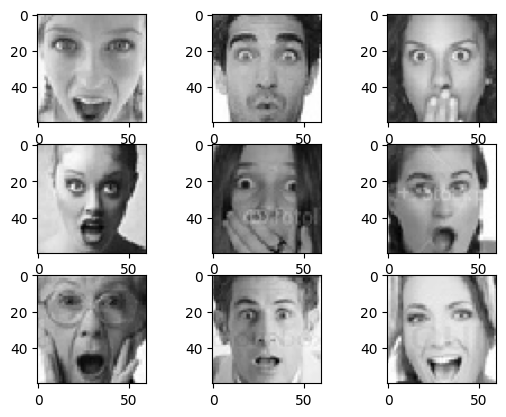

In [ ]:
render_images("surprise")

**Observations and Insights:__**

For surprise: eyebrows, widely open eyes, sometimes open mouth.

## **Checking Distribution of Classes**

Number of images for happy:    3976
Number of images for sad:    3982
Number of images for surprise:    3173
Number of images for neutral:    3978


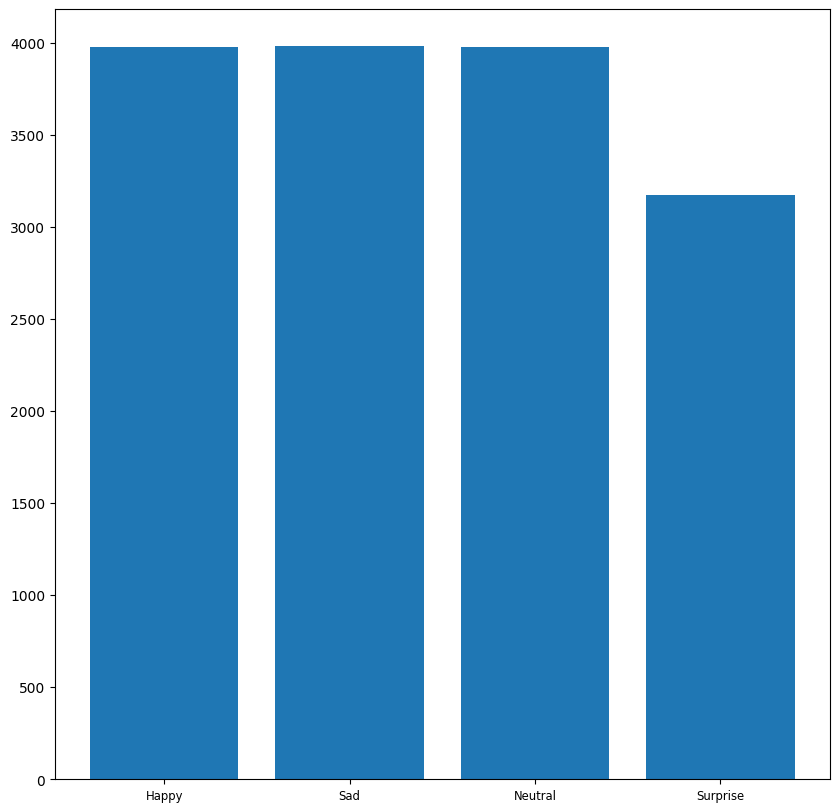

In [31]:
# Since the major part of data is training data, let's check training data distribution.

# Get the number of files in a directory
def get_distr_of_class(emotion_path):
  return len(os.listdir(folder_path + "train/" + emotion_path))


number_of_happy = get_distr_of_class("happy")
number_of_sad = get_distr_of_class("sad")
number_of_surprise = get_distr_of_class("surprise")
number_of_neutral = get_distr_of_class("neutral")

print("Number of images for happy:   ", number_of_happy)
print("Number of images for sad:   ", number_of_sad)
print("Number of images for surprise:   ", number_of_surprise)
print("Number of images for neutral:   ", number_of_neutral)


# Initializing a figure
plt.figure(figsize = (10, 10))

data = {
    'Happy': number_of_happy,
    'Sad': number_of_sad,
    'Neutral': number_of_neutral,
    'Surprise' : number_of_surprise
  }

# Creating 1D array from data
df = pd.Series(data)

# Plotting the frame's data
plt.bar(range(len(df)), df.values, align = 'center')
plt.xticks(range(len(df)), df.index.values, size = 'small')

# Render
plt.show()

**Observations and Insights:__**

The most of the images are for sad. Then for neutral. Then for happy and finally for surprise.


**Think About It:**
* Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
* Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

In [43]:
batch_size  = 32
img_size = 48
color_mode = 'rgb'

def get_channels():
  return 3 if color_mode == 'rgb' else 1

def generate_dataset():
  # generator parameters
  generator_params = {
    'horizontal_flip': True,
    'brightness_range': (0, 2),
    'rescale': 1 / 255,
    'shear_range': 0.3
  }

  # dataset params
  set_params = {
    'target_size': (img_size, img_size),
    'color_mode': color_mode or 'rgb',
    'batch_size': batch_size,
    'class_mode': 'categorical',
    'classes': ['happy', 'sad', 'neutral', 'surprise']
  }

  data_generator = ImageDataGenerator(**generator_params)

  # Creating sets for all 3 phases
  train_set = data_generator.flow_from_directory(
    folder_path + 'train',
    **set_params,
    shuffle = True
  )
  validation_set = data_generator.flow_from_directory(
    folder_path + 'validation',
    **set_params,
    shuffle = False
  )
  test_set = data_generator.flow_from_directory(
    folder_path + 'test',
    **set_params,
    shuffle = False
  )

  return {
    'train_set': train_set,
    'validation_set': validation_set,
    'test_set': test_set
  }


dataset = generate_dataset()

train_set, validation_set, test_set = dataset['train_set'], dataset['validation_set'], dataset['test_set']

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **Model Building**

**Think About It:**
* Are Convolutional Neural Networks the right approach? Should we have gone with Artificial Neural Networks instead?
* What are the advantages of CNNs over ANNs and are they applicable here?

### **Creating the Base Neural Network**

In [44]:
# Initializing sequential object
model_1 = Sequential()

# Adding Conv layer with 64 kernels
model_1.add(Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu', input_shape=(img_size, img_size, get_channels())))
# Adding max pooling to reduce the size of feature maps
model_1.add(MaxPooling2D(pool_size=(2, 2)))
# Adding dropout level to prevent overfitting
model_1.add(Dropout(0.2))

# Same operations
model_1.add(Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))

model_1.add(Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))

# Preparing outputs to become fully connected NN
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.2))

# Output
model_1.add(Dense(4, activation='softmax'))

### **Compiling and Training the Model**

In [45]:
epochs = 20

# First, let's create callbacks getter function:
def get_optimization_callbacks():
  # A checkpoint to preserve the results

  checkpoint_saver = ModelCheckpoint(
  'model_1_cp.h5',
  monitor = 'val_accuracy',
  verbose = 1,
  save_best_only = True,
  mode = 'max'
)

  # Then, let's write a checker that stops when the observed parameter is not changing anymore, so it will preserve
  # computational resources and time. In my case, then validation loss is not decreasing anymore, a convergence is achieved.

  early_stopper = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 5,
    verbose = 1
  )

  # When the observed parameter is not changing, a way to observe better is to reduce the learning rate
  # so the algorithm can observe more detailly.
  lr_reducer = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3,
    verbose = 1,
    min_delta = 0.0001
  )

  return [checkpoint_saver, early_stopper, lr_reducer]


callbacks_list = get_optimization_callbacks()

initial_lr = 0.001
optimizer = Adam(learning_rate = initial_lr)

model_1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

first_model_fitted = model_1.fit(
  train_set,
  validation_data=validation_set,
  epochs = epochs,
  batch_size = batch_size,
  callbacks = callbacks_list
)

Epoch 1/20
473/473 [==============================] - ETA: 0s - loss: 1.3711 - accuracy: 0.2953
Epoch 1: val_accuracy improved from -inf to 0.40868, saving model to model_1_cp.h5
473/473 [==============================] - 29s 57ms/step - loss: 1.3711 - accuracy: 0.2953 - val_loss: 1.2986 - val_accuracy: 0.4087 - lr: 0.0010
Epoch 2/20
  1/473 [..............................] - ETA: 33s - loss: 1.2660 - accuracy: 0.3750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - ETA: 0s - loss: 1.2436 - accuracy: 0.4332
Epoch 2: val_accuracy improved from 0.40868 to 0.50311, saving model to model_1_cp.h5
473/473 [==============================] - 27s 56ms/step - loss: 1.2436 - accuracy: 0.4332 - val_loss: 1.1471 - val_accuracy: 0.5031 - lr: 0.0010
Epoch 3/20
472/473 [============================>.] - ETA: 0s - loss: 1.1423 - accuracy: 0.4953
Epoch 3: val_accuracy improved from 0.50311 to 0.55375, saving model to model_1_cp.h5
473/473 [==============================] - 27s 56ms/step - loss: 1.1424 - accuracy: 0.4951 - val_loss: 1.0360 - val_accuracy: 0.5537 - lr: 0.0010
Epoch 4/20
472/473 [============================>.] - ETA: 0s - loss: 1.0696 - accuracy: 0.5306
Epoch 4: val_accuracy improved from 0.55375 to 0.57103, saving model to model_1_cp.h5
473/473 [==============================] - 27s 56ms/step - loss: 1.0699 - accuracy: 0.5305 - val_loss: 1.0076 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 5/20
472/473 [=======

### **Evaluating the Model on the Test Set**

In [65]:
ground_truth_labels = test_set.labels

def predict(model: Model):
  # Now, since we did not iterate over test_set, we don't need to reset it, so I will skip it.
  y_pred = model.predict(test_set)

  # Since the softmax function finds probabilities, we need to find the indices
  # for the highest probabilities using argmax
  predicted_labels = np.argmax(y_pred, axis=1)

  # Transposing results for convenience
  results_side_by_side = np.vstack((predicted_labels, ground_truth_labels)).T

  print(results_side_by_side)
  print(accuracy_score(ground_truth_labels, predicted_labels))

  return predicted_labels

predict(model_1)
print() # This line I use to avoid printing the output of predict method

4/4 [==============================] - 0s 42ms/step
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [1 0]
 [3 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [2 0]
 [1 0]
 [2 0]
 [2 0]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [0 1]
 [2 1]
 [2 1]
 [1 1]
 [0 1]
 [2 1]
 [0 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [3 1]
 [1 1]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [1 2]
 [1 2]
 [2 2]
 [2 2]
 [1 2]
 [1 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [0 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [1 2]
 [0 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [1 2]
 [3 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [0 3]
 [2 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [2 3]
 [3 3]
 [0 3]
 [3 3]
 [1 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]]
0.640625



**Observations and Insights:__**

**RGB:**

After multiple trials with RGB, I received 69.53% accuracy score on tests which still needs improvement.

`Results`:

- accuracy_score: 69.53%

- val_accuracy: 66.33%

- accuracy: 64.44%

**Grayscale:**

`Results:`

- accuracy_score: 68.75%

- val_accuracy: 64.37%

- accuracy: 66.45%



### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

In [28]:
# Switching back to RGB
color_mode = 'rgb'

# Initializing Sequential. We will start with RGB model. We can adjust params like
# kernels amount (as well as dense size), kernel size, activations (relu vs no activation by default).
model_2 = Sequential()

# Adding the first convolutional layer
model_2.add(Conv2D(256, (2, 2), padding = 'same', input_shape = (img_size, img_size, get_channels()), activation = 'relu'))
# Normalize the batch
model_2.add(BatchNormalization())
# Add a leaky relu to handle "dead" neurons
model_2.add(LeakyReLU(alpha = 0.1))
# Adding maxpooling layer
model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding the second convolutional layer
model_2.add(Conv2D(128, (2, 2), padding = 'same', activation = 'relu'))
# Normalize the batch
model_2.add(BatchNormalization())
# Add a leaky relu to handle "dead" neurons
model_2.add(LeakyReLU(alpha = 0.1))
# Adding maxpooling layer
model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding the third convolutional layer
model_2.add(Conv2D(64, (2, 2), padding = 'same', activation = 'relu'))
# Normalize the batch
model_2.add(BatchNormalization())
# Add a leaky relu to handle "dead" neurons
model_2.add(LeakyReLU(alpha = 0.1))
# Adding maxpooling layer
model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding the fourth convolutional layer
model_2.add(Conv2D(32, (2, 2), padding = 'same', activation = 'relu'))
# Making a flatten layer to create a fully connected dense layer with its bias and
# weights
model_2.add(Flatten())
# Adding the fully connected layer
model_2.add(Dense(512, activation = 'relu'))
# Adding the second fully connected layer
model_2.add(Dense(256, activation = 'relu'))

# Dropping random neurons
model_2.add(Dropout(0.2))

# Adding the output layer
model_2.add(Dense(4, activation = 'softmax'))

### **Compiling and Training the Model**

In [30]:
initial_lr = 0.0001
optimizer = Adam(learning_rate=initial_lr)

# Compiling
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting
second_model_fitted = model_2.fit(
  train_set,
  validation_data = validation_set,
  epochs = epochs,
  batch_size = batch_size,
  callbacks = callbacks_list
)

Epoch 1/20
472/473 [============================>.] - ETA: 0s - loss: 0.9437 - accuracy: 0.5967
Epoch 1: val_accuracy improved from 0.59916 to 0.60338, saving model to model_2_cp.h5
473/473 [==============================] - 21s 38ms/step - loss: 0.9438 - accuracy: 0.5966 - val_loss: 0.9457 - val_accuracy: 0.6034 - lr: 1.0000e-04
Epoch 2/20
  3/473 [..............................] - ETA: 13s - loss: 0.8980 - accuracy: 0.6042

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


472/473 [============================>.] - ETA: 0s - loss: 0.9135 - accuracy: 0.6097
Epoch 2: val_accuracy improved from 0.60338 to 0.61463, saving model to model_2_cp.h5
473/473 [==============================] - 18s 38ms/step - loss: 0.9136 - accuracy: 0.6096 - val_loss: 0.9241 - val_accuracy: 0.6146 - lr: 1.0000e-04
Epoch 3/20
472/473 [============================>.] - ETA: 0s - loss: 0.8849 - accuracy: 0.6254
Epoch 3: val_accuracy improved from 0.61463 to 0.61804, saving model to model_2_cp.h5
473/473 [==============================] - 18s 38ms/step - loss: 0.8847 - accuracy: 0.6256 - val_loss: 0.8984 - val_accuracy: 0.6180 - lr: 1.0000e-04
Epoch 4/20
472/473 [============================>.] - ETA: 0s - loss: 0.8614 - accuracy: 0.6327
Epoch 4: val_accuracy did not improve from 0.61804

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
473/473 [==============================] - 17s 37ms/step - loss: 0.8619 - accuracy: 0.6322 - val_loss: 0.9139 - val_accurac

### **Evaluating the Model on the Test Set**

In [31]:
predict(model_2)

4/4 [==============================] - 0s 30ms/step
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 0]
 [3 0]
 [0 0]
 [0 0]
 [0 0]
 [3 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [0 1]
 [0 1]
 [2 1]
 [0 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [0 1]
 [2 1]
 [0 1]
 [1 1]
 [2 1]
 [2 2]
 [1 2]
 [2 2]
 [1 2]
 [2 2]
 [1 2]
 [2 2]
 [1 2]
 [2 2]
 [1 2]
 [1 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [1 2]
 [0 2]
 [2 2]
 [0 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [1 2]
 [0 3]
 [2 3]
 [2 3]
 [3 3]
 [3 3]
 [0 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [1 3]
 [3 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [1 3]
 [2 3]
 [3 3]
 [3 3]
 [1 3]
 [3 3]
 [0 3]
 [1 3]
 [1 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]]
0.6015625


**Observations and Insights:__**


**RGB:**

After multiple trials with RGB, I received 69.53% accuracy score on tests which still needs improvement.

`Results`:

- accuracy_score: 60.16%

- val_accuracy: 61.20%

- accuracy: 63.22%

**Grayscale:**

`Results:`

- accuracy_score: 53.13%

- val_accuracy: 59.92%

- accuracy: 57.58%

Additional layers did not improve the performance of the network. However, again, RGB performed better.



## **Think About It:**

* Did the models have a satisfactory performance? If not, then what are the possible reasons?
* Which Color mode showed better overall performance? What are the possible reasons? Do you think having 'rgb' color mode is needed because the images are already black and white?

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [42]:
# Assuring the data is in RGB because it's important for TL
color_mode = 'rgb'

# Generate dataset
dataset = generate_dataset()

train_set, validation_set, test_set = dataset['train_set'], dataset['validation_set'], dataset['test_set']

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [70]:
from tensorflow.keras.applications import VGG16

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [71]:
epochs = 20

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (img_size, img_size, get_channels()))

for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)

x = Dense(32, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output_layer = Dense(4, activation = 'softmax')(x)

vgg_model = Model(vgg.input, output_layer)

58889256/58889256 [==============================] - 4s 0us/step


### **Compiling and Training the VGG16 Model**

In [72]:
# For better practice, here I monitored val_loss instead of val_accuracy, with
# mode = 'min' instead of max since the the less is val_loss, the higher is accuracy.
checkpoint = ModelCheckpoint(
  "./vgg.h5",
  monitor = 'val_loss',
  verbose = 1,
  save_best_only = True,
  mode = 'min'
)
early_stopping = EarlyStopping(
  monitor = 'val_loss',
  min_delta = 0,
  patience = 3,
  verbose = 1,
  restore_best_weights = True
)
reduce_learningrate = ReduceLROnPlateau(
  monitor = 'val_loss',
  factor = 0.2,
  patience = 2,
  verbose = 1,
  min_delta = 0.0001
)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

optimizer = Adam(learning_rate = 0.001)

vgg_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

vgg_model_fitted = vgg_model.fit(
  train_set,
  validation_data = validation_set,
  epochs = epochs,
  batch_size = batch_size,
  callbacks = callbacks_list
)

Epoch 1/20
473/473 [==============================] - ETA: 0s - loss: 1.3661 - accuracy: 0.3466
Epoch 1: val_loss improved from inf to 1.26712, saving model to ./vgg.h5
473/473 [==============================] - 32s 60ms/step - loss: 1.3661 - accuracy: 0.3466 - val_loss: 1.2671 - val_accuracy: 0.3647 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


472/473 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.4338
Epoch 2: val_loss did not improve from 1.26712
473/473 [==============================] - 27s 57ms/step - loss: 1.2308 - accuracy: 0.4340 - val_loss: 1.2921 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 3/20
473/473 [==============================] - ETA: 0s - loss: 1.1986 - accuracy: 0.4601
Epoch 3: val_loss improved from 1.26712 to 1.18528, saving model to ./vgg.h5
473/473 [==============================] - 27s 57ms/step - loss: 1.1986 - accuracy: 0.4601 - val_loss: 1.1853 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 4/20
473/473 [==============================] - ETA: 0s - loss: 1.1732 - accuracy: 0.4724
Epoch 4: val_loss improved from 1.18528 to 1.16372, saving model to ./vgg.h5
473/473 [==============================] - 27s 58ms/step - loss: 1.1732 - accuracy: 0.4724 - val_loss: 1.1637 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 5/20
473/473 [==============================] - ETA: 0s - loss: 1.1704 - accur

### **Evaluating the VGG16 model**

In [74]:
predict(vgg_model)

4/4 [==============================] - 0s 41ms/step
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [0 0]
 [1 0]
 [2 0]
 [0 0]
 [2 0]
 [2 0]
 [1 0]
 [2 0]
 [0 0]
 [2 0]
 [2 0]
 [0 0]
 [2 0]
 [0 0]
 [3 0]
 [0 0]
 [2 0]
 [1 0]
 [0 0]
 [2 0]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [0 1]
 [2 1]
 [1 1]
 [0 1]
 [2 1]
 [0 1]
 [2 1]
 [2 1]
 [0 1]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [3 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 2]
 [0 2]
 [1 2]
 [2 2]
 [0 2]
 [1 2]
 [0 2]
 [0 2]
 [2 2]
 [0 2]
 [2 2]
 [0 2]
 [0 2]
 [1 2]
 [3 2]
 [0 2]
 [2 2]
 [2 2]
 [1 2]
 [0 2]
 [1 2]
 [1 2]
 [0 2]
 [2 2]
 [2 2]
 [2 2]
 [3 2]
 [2 2]
 [2 2]
 [2 2]
 [0 2]
 [1 2]
 [2 3]
 [1 3]
 [2 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]
 [1 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [1 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [2 3]
 [2 3]
 [1 3]
 [3 3]
 [1 3]
 [3 3]
 [3 3]]
0.5078125


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 2, 0, 2, 2,
       0, 2, 0, 3, 0, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1,
       0, 2, 0, 2, 2, 0, 1, 0, 0, 1, 1, 1, 2, 3, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 1, 3, 0, 2, 2, 1, 0, 1, 1, 0, 2,
       2, 2, 3, 2, 2, 2, 0, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 2, 1, 3, 1, 3, 3])

**Think About It:**

- What do you infer from the general trend in the training performance?
- Is the training accuracy consistently improving?
- Is the validation accuracy also improving similarly?

**Observations and Insights:__**

`Results:`
256 - 128 - 64:
- accuracy_score: 47.66%
- accuracy: 53.48%
- val_accuracy: 51.54%


Despite we used transfer learning with imagenet dataset, the results I got are worse. Decreasing learning rate and increasing dense neurons, as well as adding LeakyReLU for avoiding dead neurons also did not improve enough the model. However, since the model is pretrained, it starts the 1st epoch with a lower loss.


I added additional layers (64 and 32), and it icreased accuracy_score only by 3%.

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [66]:
from tensorflow.keras.applications import ResNet101

resnet = ResNet101(include_top = False, weights = "imagenet", input_shape=(img_size, img_size, get_channels()))

171446536/171446536 [==============================] - 9s 0us/step


### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.

In [67]:
# Retrieving the last layer
transfer_layer_resnet = resnet.get_layer('conv5_block3_add')

# Mutation lock
for layer in resnet.layers[:-10]:
  layer.trainable = False

x = Flatten()(transfer_layer_resnet.output)

x = Dense(512, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)

x = Dropout(0.3)(x)

x = Dense(32, activation = 'relu')(x)

x = BatchNormalization()(x)

output_layer = Dense(4, activation = 'softmax')(x)

resnet_model = Model(resnet.input, output_layer)


### **Compiling and Training the Model**

In [68]:
optimizer = Adam(0.0005)

resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

resnet_model_fitted = resnet_model.fit(
  train_set,
  validation_data = validation_set,
  epochs = epochs,
  batch_size = batch_size,
  callbacks = callbacks_list
)


Epoch 1/35
473/473 [==============================] - ETA: 0s - loss: 1.4564 - accuracy: 0.2838
Epoch 1: val_accuracy did not improve from 0.68375
473/473 [==============================] - 43s 69ms/step - loss: 1.4564 - accuracy: 0.2838 - val_loss: 1.3458 - val_accuracy: 0.2729 - lr: 0.0010
Epoch 2/35
472/473 [============================>.] - ETA: 0s - loss: 1.3279 - accuracy: 0.3291
Epoch 2: val_accuracy did not improve from 0.68375
473/473 [==============================] - 29s 61ms/step - loss: 1.3281 - accuracy: 0.3289 - val_loss: 1.2969 - val_accuracy: 0.3725 - lr: 0.0010
Epoch 3/35
473/473 [==============================] - ETA: 0s - loss: 1.3063 - accuracy: 0.3575
Epoch 3: val_accuracy did not improve from 0.68375
473/473 [==============================] - 29s 62ms/step - loss: 1.3063 - accuracy: 0.3575 - val_loss: 1.4905 - val_accuracy: 0.2493 - lr: 0.0010
Epoch 4/35
472/473 [============================>.] - ETA: 0s - loss: 1.2939 - accuracy: 0.3670
Epoch 4: val_accuracy did

### **Evaluating the ResNet Model**

In [69]:
predict(resnet_model)
print()

4/4 [==============================] - 2s 51ms/step
[[2 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [3 0]
 [0 0]
 [0 0]
 [3 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [2 0]
 [0 0]
 [2 0]
 [2 0]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [0 1]
 [0 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [3 1]
 [0 1]
 [1 1]
 [2 1]
 [1 1]
 [2 1]
 [1 1]
 [0 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [0 1]
 [0 1]
 [0 2]
 [2 2]
 [0 2]
 [1 2]
 [0 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [0 2]
 [3 2]
 [1 2]
 [1 2]
 [2 2]
 [0 2]
 [2 2]
 [0 2]
 [2 2]
 [0 2]
 [0 2]
 [2 2]
 [2 2]
 [3 3]
 [3 3]
 [0 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]
 [0 3]
 [3 3]
 [3 3]
 [1 3]
 [3 3]
 [3 3]
 [3 3]
 [0 3]
 [3 3]
 [0 3]
 [3 3]
 [3 3]
 [3 3]
 [0 3]
 [3 3]
 [0 3]
 [3 3]
 [0 3]
 [3 3]
 [2 3]
 [3 3]
 [2 3]]
0.5078125


array([2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 3, 0, 0, 3, 0,
       0, 1, 0, 0, 0, 1, 2, 0, 2, 2, 1, 2, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2,
       3, 0, 1, 2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2,
       0, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 3, 1, 1, 2,
       0, 2, 0, 2, 0, 0, 2, 2, 3, 3, 0, 3, 2, 3, 3, 2, 3, 3, 0, 3, 3, 1,
       3, 3, 3, 0, 3, 0, 3, 3, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2])

**Observations and Insights:__**

`Results:`

To improve performance of this model I had to make the last 10 layers trainable, otherwise, most of the architectures I tried gave me very poor outputs. Although, the performance is still poor.

- accuracy_score: 50%
- accuracy: 45.06%
- val_accuracy: 46.03%

**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

In [12]:
from tensorflow.keras.applications import EfficientNetV2B2

color_mode = 'rgb'

effnet = EfficientNetV2B2(include_top = False, weights = 'imagenet', input_shape = (img_size, img_size, get_channels()))

effnet.summary()

35839040/35839040 [==============================] - 3s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 48, 48, 3)            0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2

### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [21]:
transfer_layer_effnet = effnet.get_layer('block6j_activation')

# Make only last 10 layers untrainable
for layer in effnet.layers[-10:]:
  layer.trainable = False


x = AveragePooling2D((7, 7), padding = 'same')(transfer_layer_effnet.output)

x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)

output_layer = Dense(4, activation = 'softmax')(x)

effnet_model = Model(effnet.input, output_layer)

Epoch 1/20
473/473 [==============================] - ETA: 0s - loss: 1.2869 - accuracy: 0.3866
Epoch 1: val_accuracy improved from -inf to 0.20334, saving model to model_1_cp.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - 98s 90ms/step - loss: 1.2869 - accuracy: 0.3866 - val_loss: 1.4337 - val_accuracy: 0.2033 - lr: 0.0010
Epoch 2/20
473/473 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.5568
Epoch 2: val_accuracy improved from 0.20334 to 0.23046, saving model to model_1_cp.h5
473/473 [==============================] - 39s 83ms/step - loss: 1.0499 - accuracy: 0.5568 - val_loss: 1.3725 - val_accuracy: 0.2305 - lr: 0.0010
Epoch 3/20
473/473 [==============================] - ETA: 0s - loss: 0.9472 - accuracy: 0.6042
Epoch 3: val_accuracy did not improve from 0.23046
473/473 [==============================] - 38s 81ms/step - loss: 0.9472 - accuracy: 0.6042 - val_loss: 1.4678 - val_accuracy: 0.2293 - lr: 0.0010
Epoch 4/20
473/473 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.6352
Epoch 4: val_accuracy improved from 0.23046 to 0.23066, saving model to model_1_cp.h5
473/473 [==============================] - 40s 84ms

### **Compiling and Training the Model**

In [ ]:
effnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

effnet_model_fitted = effnet_model.fit(
  train_set,
  validation_data = validation_set,
  epochs = epochs,
  batch_size = batch_size,
  callbacks = callbacks_list
)

### **Evaluating the EfficientnetNet Model**

In [22]:
predict(effnet_model)

4/4 [==============================] - 3s 32ms/step
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [1 0]
 [0 0]
 [2 0]
 [2 0]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [3 1]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [1 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [1 2]
 [1 3]
 [2 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [1 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [0 3]
 [3 3]
 [0 3]
 [3 3]
 [1 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]]
0.796875


**Observations and Insights:__**

`Results:`

- accuracy_score: 79.69%
- accuracy: 83.47%
- val_accuracy: 74.20%

This model shows the best performance compared to all other models.

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [49]:
dataset = generate_dataset()

train_set, validation_set, test_set = dataset['train_set'], dataset['validation_set'], dataset['test_set']

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

In [51]:
complex_cnn_model = Sequential()

# First Convolutional block
complex_cnn_model.add(Conv2D(64, kernel_size=2, padding='same', activation='relu', input_shape=(img_size, img_size, get_channels())))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(LeakyReLU(0.1))
complex_cnn_model.add(MaxPooling2D(pool_size=2))
complex_cnn_model.add(Dropout(0.2))

# Second Convolutional block
complex_cnn_model.add(Conv2D(128, kernel_size=2, padding='same', activation='relu'))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(LeakyReLU(0.1))
complex_cnn_model.add(MaxPooling2D(pool_size=2))
complex_cnn_model.add(Dropout(0.2))

# Third Convolutional block
complex_cnn_model.add(Conv2D(512, kernel_size=2, padding='same', activation='relu'))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(LeakyReLU(0.1))
complex_cnn_model.add(MaxPooling2D(pool_size=2))
complex_cnn_model.add(Dropout(0.2))

# Fourth Convolutional block
complex_cnn_model.add(Conv2D(512, kernel_size=2, padding='same', activation='relu'))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(LeakyReLU(0.1))
complex_cnn_model.add(MaxPooling2D(pool_size=2))
complex_cnn_model.add(Dropout(0.2))

# Fifth Convolutional block
complex_cnn_model.add(Conv2D(128, kernel_size=2, padding='same', activation='relu'))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(LeakyReLU(0.1))
complex_cnn_model.add(MaxPooling2D(pool_size=2))
complex_cnn_model.add(Dropout(0.2))

# Flatten layer
complex_cnn_model.add(Flatten())

# First fully connected block
complex_cnn_model.add(Dense(256))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(Activation('relu'))
complex_cnn_model.add(Dropout(0.2))

# Second fully cnnected block
complex_cnn_model.add(Dense(512))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(Activation('relu'))
complex_cnn_model.add(Dropout(0.2))

# Dense layer
complex_cnn_model.add(Dense(4, activation='softmax'))

### **Compiling and Training the Model**

In [52]:
# Here I create hyperparameters
epochs = 35
steps_per_epoch = train_set.n // train_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

# And new callbacks for complex CNN (3rd custom model)
checkpoint = ModelCheckpoint(
  "model3.h5",
  monitor = 'val_accuracy',
  save_weights_only = True,
  model = 'max',
  verbose = 1
)
reduce_lr = ReduceLROnPlateau(
  monitor = 'val_loss',
  factor = 0.1,
  patience = 2,
  min_lr = 0.0001,
  model = 'auto'
)

callbacks = [checkpoint, reduce_lr]

optimizer = Adam(learning_rate = 0.0001)
complex_cnn_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

complex_cnn_model_fitted = complex_cnn_model.fit(
  train_set,
  validation_data = validation_set,
  epochs = epochs,
  steps_per_epoch = steps_per_epoch,
  validation_steps = validation_steps,
  callbacks = callbacks
)

Epoch 1/35
471/472 [============================>.] - ETA: 0s - loss: 1.5834 - accuracy: 0.2572
Epoch 1: saving model to model3.h5
472/472 [==============================] - 34s 58ms/step - loss: 1.5831 - accuracy: 0.2572 - val_loss: 1.3454 - val_accuracy: 0.3679 - lr: 1.0000e-04
Epoch 2/35
471/472 [============================>.] - ETA: 0s - loss: 1.5107 - accuracy: 0.2665
Epoch 2: saving model to model3.h5
472/472 [==============================] - 27s 57ms/step - loss: 1.5108 - accuracy: 0.2664 - val_loss: 1.3592 - val_accuracy: 0.2915 - lr: 1.0000e-04
Epoch 3/35
471/472 [============================>.] - ETA: 0s - loss: 1.4783 - accuracy: 0.2808
Epoch 3: saving model to model3.h5
472/472 [==============================] - 27s 57ms/step - loss: 1.4783 - accuracy: 0.2808 - val_loss: 1.3423 - val_accuracy: 0.3163 - lr: 1.0000e-04
Epoch 4/35
472/472 [==============================] - ETA: 0s - loss: 1.4570 - accuracy: 0.2878
Epoch 4: saving model to model3.h5
472/472 [=================

### **Evaluating the Model on Test Set**

In [55]:
predict(complex_cnn_model)
print('Prediction is outputed above.')

4/4 [==============================] - 0s 42ms/step
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [2 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [3 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [2 1]
 [1 1]
 [1 1]
 [2 1]
 [2 1]
 [1 1]
 [1 1]
 [2 1]
 [2 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [2 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [0 1]
 [2 1]
 [1 1]
 [0 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [1 2]
 [2 2]
 [2 2]
 [0 2]
 [2 2]
 [3 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [1 2]
 [3 3]
 [2 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [0 3]
 [3 3]
 [3 3]
 [3 3]
 [0 3]
 [3 3]
 [0 3]
 [3 3]
 [1 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]]
0.71875
Prediction is outputed above.


**Observations and Insights:__**

This model shows less accurate results than EfficientNet, and EfficientNet is better since it is already pretrained - saving computation resources.

`Results:`

- accuracy_score: 71.88%
- accuracy: 66.55%
- val_accuracy: 69.48%

### **Plotting the Confusion Matrix for the chosen final model**

4/4 [==============================] - 0s 47ms/step
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [2 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [2 1]
 [3 1]
 [1 1]
 [2 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [2 2]
 [1 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [0 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [1 2]
 [3 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [1 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]
 [3 3]
 [1 3]
 [3 3]
 [2 3]
 [3 3]
 [3 3]]
0.84375
[[30  1  1  0]
 [ 0 24  7  1]
 [ 1  4 27  0

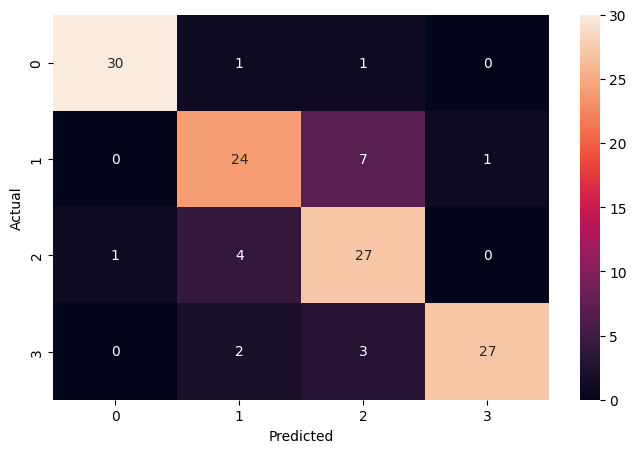

In [64]:
predicted_labels = predict(effnet_model)

cm = confusion_matrix(ground_truth_labels, predicted_labels)

print(cm)

plt.figure(figsize = (8, 5))

# create a heatmap
sns.heatmap(cm, annot = True,  fmt = '.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the confusion matrix heatmap
plt.show()

**Observations and Insights:__**

As we see, mostly actual and predicted values correspond to each other. From the matrix we can see, that most of the times the model errored when defining sad (index is 1)  and neutral images (index is 2).

## **Conclusion:____________**

The model I will go with is EfficientNet. Here is why.

1. First from-scratch CNN models do not show high accuracy.
2. Other pretrained models also are not as accurate as this model.
3. It's accuracy is higher than of the complex CNN.

Overall, it shows accuracy_score of 79.69%, accuracy of 83.47 and val_accuracy: 74.20%, and, despite that there can be overfitting present, it still shows good results and its train and val_accuracy are higher than the second best model - complex CNN. Considering that this type of recognition models are rarely used in medicine or other industries requiring greatest precision, this model performs well.

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

1. RGB performs better, and that is the reason why pretrained models use RGB.
2. Pretrained models not always perform better due to the nature of the data.

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

1. In my case, ResNet with using residual blocks and with 10 layers trainable performed much worse than a from-scratch model.
2. Scope to improve the performance further, of course, exists. Since the resources are limited here, I went with 80% accuracy. However, with appropriate resources available, we can achieve better results, especially using pretrained models.
3. Complex CNN from scratch shown a better result than 2 of pretrained models despite that I tried different architectures.

### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?
As I already mentioned, the EfficientNet outperforms other models and it is already pretrained, which saves resources: both time and and computational ones.